In [15]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import local_maxima, erosion, dilation, opening, closing, disk
from skimage.segmentation import watershed
from skimage.measure import label, regionprops
from scipy.ndimage import distance_transform_edt as distance
from skimage.color import label2rgb
from skimage.exposure import equalize_adapthist
from skimage import morphology
def minmax(image):
    out = ((image - image.min()) / (image.max() - image.min()))
    return out
image = tiff.imread('/home/phillip/documents/yen-lab-discussion/rfp/Lyz Fabp1/CDKO 158.1/Jej-2.tif')
_, crypts, dapi = minmax(image[:,:,0]), minmax(image[:,:,1]), minmax(image[:,:,2])




In [16]:
import numpy as np
import cv2
from numpy.typing import NDArray
from cv2 import inpaint

def remove_rectangles(
    image: NDArray[np.uint8],
    *,
    stacks: NDArray[np.uint8] | None = None,   # optional: (N, H, W) stack for "same intensity across stacks"
    white_thresh: int = 240,
    same_tol: int = 5,                         # max allowed (max-min) across stacks/channels to count as "same"
    area_min: int = 10,                        # min connected area to inpaint for flat-white regions
    aspect_low: float = 0.2,
    aspect_high: float = 5.0,
    dilation_kernel: tuple[int, int] = (15, 15),
    inpaint_radius: int = 15
) -> NDArray[np.uint8]:
    """
    Remove rectangular artifacts + 'flat-white' text/graphics that are the same across stacks.
    - If `stacks` is provided (N,H,W), 'same across stacks' uses that.
    - Otherwise, uses across-channel flatness on the provided RGB image.
    """

    # -------- base grayscale + rectangles-by-aspect --------
    if image.ndim == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        H, W = gray.shape
    else:
        gray = image
        H, W = gray.shape

    _, bm = cv2.threshold(gray, white_thresh, 255, cv2.THRESH_BINARY)
    cnts, _ = cv2.findContours(bm, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    rect_mask = np.zeros((H, W), dtype=np.uint8)
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        if w == 0 or h == 0:
            continue
        ar = w / h
        # NOTE: original code inpainted rectangles *outside* the aspect range.
        # Keep that logic (text under rectangles is usually caught by the flat-white path below).
        if ar < aspect_low or ar > aspect_high:
            cv2.rectangle(rect_mask, (x, y), (x + w, y + h), 255, -1)

    # -------- flat-white-across-stacks (text/labels) --------
    # Build a flatness/brightness mask either from explicit stacks or image channels.
    if stacks is not None:
        # stacks: (N, H, W) uint8
        if stacks.ndim != 3 or stacks.shape[1:] != (H, W):
            raise ValueError("`stacks` must be shaped (N, H, W) and match image size.")
        # across-stack flatness
        smin = stacks.min(axis=0).astype(np.int16)
        smax = stacks.max(axis=0).astype(np.int16)
        flat = (smax - smin) <= same_tol
        bright = (stacks.mean(axis=0) >= white_thresh)
        flat_white_mask = (flat & bright).astype(np.uint8) * 255
    else:
        # Use across-channel flatness if we have color; if grayscale, there is no channel flatness.
        if image.ndim == 3 and image.shape[2] >= 3:
            ch = image[:, :, :3].astype(np.int16)
            cmin = ch.min(axis=2)
            cmax = ch.max(axis=2)
            flat = (cmax - cmin) <= same_tol
            bright = (ch.mean(axis=2) >= white_thresh)
            flat_white_mask = (flat & bright).astype(np.uint8) * 255
        else:
            # With only grayscale and no stacks, skip the flat-white channel test (not enough info).
            flat_white_mask = np.zeros((H, W), dtype=np.uint8)

    # Clean up flat-white mask: connect characters slightly, then drop tiny specks
    if flat_white_mask.any():
        flat_white_mask = cv2.dilate(flat_white_mask, np.ones((3, 3), np.uint8), iterations=1)

        # Area filter via connected components
        num, labels, stats, _ = cv2.connectedComponentsWithStats((flat_white_mask > 0).astype(np.uint8), connectivity=8)
        kept = np.zeros((H, W), dtype=np.uint8)
        for i in range(1, num):
            area = stats[i, cv2.CC_STAT_AREA]
            if area >= area_min:
                kept[labels == i] = 255
        flat_white_mask = kept

    # -------- combine masks and inpaint --------
    mask = rect_mask.copy()
    if flat_white_mask.any():
        mask = cv2.bitwise_or(mask, flat_white_mask)

    if not mask.any():
        return image.copy()

    mask = cv2.dilate(mask, np.ones(dilation_kernel, np.uint8), iterations=1)
    return cv2.inpaint(image, mask, inpaint_radius, cv2.INPAINT_TELEA)



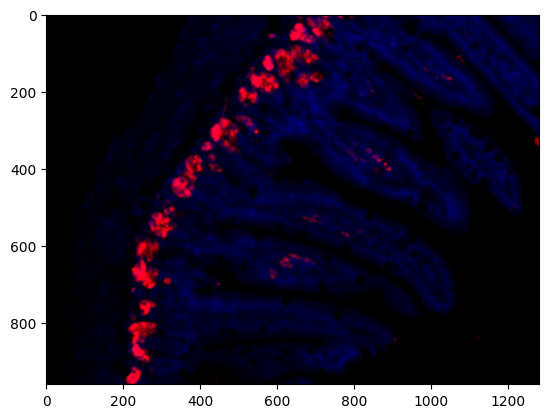

In [17]:
evil_G3FR = remove_rectangles(tiff.imread('/home/phillip/documents/lysozyme/lysozyme images/Jej LYZ/G3/G3FR - 2.tif'))
plt.imshow(evil_G3FR)

list_of_images_to_try = [ #(crypt, dapi)
    ("Jej-2",tiff.imread('/home/phillip/documents/yen-lab-discussion/rfp/Lyz Fabp1/CDKO 158.1/Jej-2c2.tif')[...,1],
     tiff.imread('/home/phillip/documents/yen-lab-discussion/rfp/Lyz Fabp1/CDKO 158.1/Jej-2c1.tif')[...,2]),
    ("Jej-3",tiff.imread('/home/phillip/documents/yen-lab-discussion/rfp/Lyz Fabp1/CDKO 158.1/Jej-3c2.tif')[...,1],
     tiff.imread('/home/phillip/documents/yen-lab-discussion/rfp/Lyz Fabp1/CDKO 158.1/Jej-3c1.tif')[...,2]),
    ("G3FR",evil_G3FR[...,0],
     evil_G3FR[...,2])
    ]


In [28]:
from skimage.morphology import white_tophat

def opencv_dilate_disk(img, r):
    k = 2*r + 1
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
    # OpenCV likes uint8/float32; keep float32 if you want

    return cv2.dilate(img, se)

def caps(image, small_r, big_r):
    image1 = image - white_tophat(image, disk(small_r))
    #selem_small, selem_large = disk(small_r), disk(big_r)    
    hats = opencv_dilate_disk(image1, big_r) - opencv_dilate_disk(image1, small_r) 
    clean = image1 - np.minimum(image1, hats) 
    troughs = np.maximum(image1, hats) - image1
    return hats, clean, troughs
#cell_hats = caps(b_eq, 2, 20)

def show_caps(image, small_r, big_r) -> tuple[NDArray, NDArray, NDArray]: # hats, clean, troughs

    hats, clean, troughs = caps(image, small_r, big_r)

    fig, ax = plt.subplots(1,4, figsize=(30,5))
    ax[0].axis('off'); ax[1].axis('off'); ax[2].axis('off'); ax[3].axis('off');
    ax[0].imshow(image, cmap='gray')
    ax[1].imshow(hats, cmap='gray')
    ax[2].imshow(clean, cmap='gray')
    ax[3].imshow(troughs, cmap='gray')
    fig.colorbar(ax[1].imshow(hats, cmap='gray'), ax=ax[1])
    fig.colorbar(ax[2].imshow(clean, cmap='gray'), ax=ax[2])
    fig.colorbar(ax[3].imshow(troughs, cmap='gray'), ax=ax[3])
    fig.show()
    return hats, clean, troughs

# rectified_diff
Short name: pixel-wise positive difference (a.k.a. rectified difference).

- Math: 
    - thinned_crypts = max(crypt_clean - tissue_clean, 0) → the positive part (a-b)_+.
Same for split_crypts with tissue_troughs.

- In morphology terms: 
    - this is the grayscale set difference (fuzzy set difference), analogous to binary A \ B, but with intensities.

- In pipeline-speak:
    - a competitive mask / gating step—keep signal where the crypt channel dominates the tissue channel; zero elsewhere.


In [32]:


tissue_hats, tissue_clean, tissue_troughs = caps(
    equalize_adapthist(dapi), 
    1, 
    20)
crypt_hats, crypt_clean, crypt_troughs = caps(crypts, 1, 20)

thinned_crypts = np.maximum( crypt_clean - tissue_clean, 0)#crypt_clean - np.minimum(crypt_clean, tissue_clean)
split_crypts = np.maximum(crypt_clean - tissue_troughs, 0)

good_crypts = minmax(
    opening(
        split_crypts * thinned_crypts,
        footprint = disk(radius=5)
        )**(1/2)
    )
distance = tissue_troughs - good_crypts
maxi = local_maxima(good_crypts)
segmented_crypts = label(
    watershed(
        distance,
        markers = maxi,
        mask = tissue_troughs<good_crypts
    )
)

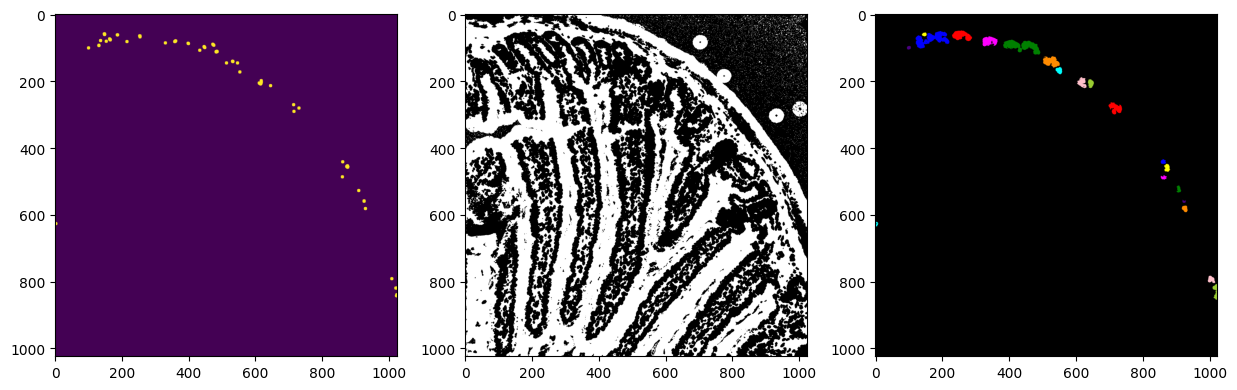

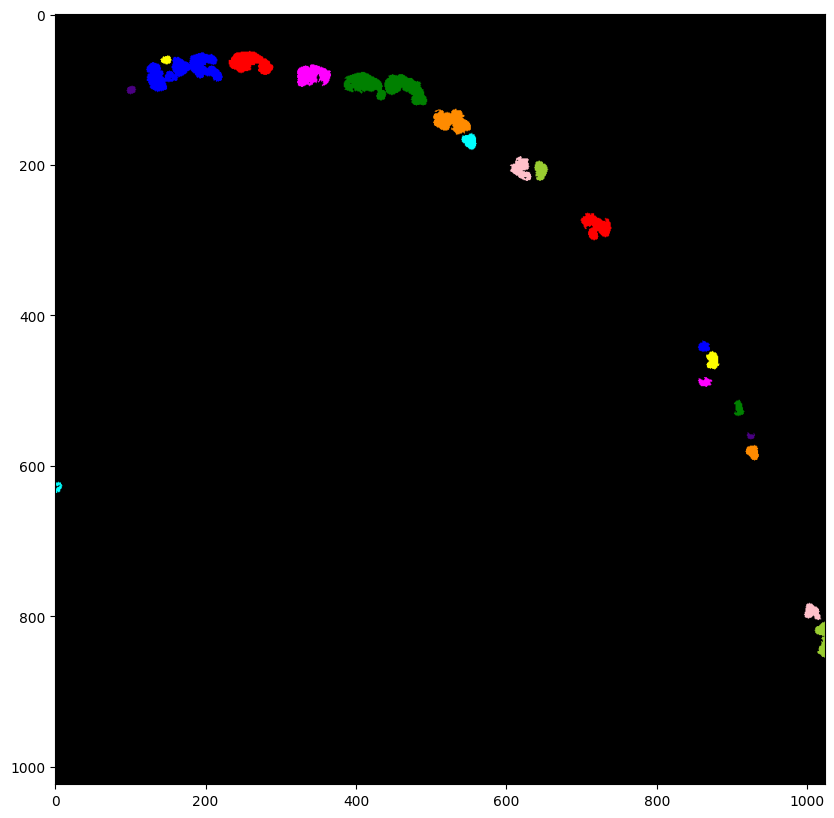

In [33]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(maxi)
ax[1].imshow(tissue_troughs>good_crypts, cmap='gray')
ax[2].imshow(
    label2rgb(label(watershed(distance, markers = maxi, mask = tissue_troughs<good_crypts)))
)
fig.show()
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(label2rgb(segmented_crypts))
fig.show()

In [21]:
import cv2
from scipy.ndimage import label as ndi_label
from skimage.segmentation import expand_labels
from scipy.ndimage import distance_transform_edt

def identify_potential_crypts(crypt_img, tissue_image, blob_size_px=30, debug=False):
    """Identify potential crypt regions using the original watershed pipeline."""

    if crypt_img.shape != tissue_image.shape:
        raise ValueError(f"Image shape mismatch: red {crypt_img.shape} vs blue {tissue_image.shape}")

    red_img = minmax(crypt_img.astype(np.float32, copy=False))
    blue_img = minmax(tissue_image.astype(np.float32, copy=False))

    debug_info = {} if debug else None
    if debug:
        print(
            f"[EXTRACTOR DEBUG] Input red: shape {red_img.shape}, range [{red_img.min():.2f}, {red_img.max():.2f}]"
        )
        print(
            f"[EXTRACTOR DEBUG] Input blue: shape {blue_img.shape}, range [{blue_img.min():.2f}, {blue_img.max():.2f}]"
        )

    red = red_img
    blue = blue_img

    if debug:
        print(f"[EXTRACTOR DEBUG] Red from display: range [{red.min():.2f}, {red.max():.2f}]")
        print(f"[EXTRACTOR DEBUG] Blue from display: range [{blue.min():.2f}, {blue.max():.2f}]")

    mask_r_dilation = np.maximum(blue, red)
    mask_r_erosion = np.minimum(blue, red)

    # if debug:
    #     debug_info['mask_r_dilation'] = mask_r_dilation.copy()
    #     debug_info['mask_r_erosion'] = mask_r_erosion.copy()
    #     print(
    #         f"[EXTRACTOR DEBUG] Dilation mask range: [{mask_r_dilation.min():.2f}, {mask_r_dilation.max():.2f}]"
    #     )
    #     print(
    #         f"[EXTRACTOR DEBUG] Erosion mask range: [{mask_r_erosion.min():.2f}, {mask_r_erosion.max():.2f}]"
    #     )

    effective_blob = float(blob_size_px) if blob_size_px else 1.0
    erosion_dim = max(3, int(round(effective_blob / 10.0)))
    if erosion_dim % 2 == 0:
        erosion_dim += 1
    erosion_footprint = np.ones((erosion_dim, erosion_dim), dtype=bool)

    diff_r = red > mask_r_erosion

    # if debug:
    #     debug_info['diff_r_raw'] = diff_r.copy()
    #     print(f"[EXTRACTOR DEBUG] diff_r raw: {np.sum(diff_r)} pixels")

    min_region_area = max(20, int(round((effective_blob ** 2) / 16.0)))
    diff_r = morphology.binary_erosion(diff_r, footprint=erosion_footprint)
    diff_r = morphology.remove_small_objects(diff_r, min_size=min_region_area)

    # if debug:
    #     debug_info['diff_r'] = diff_r.copy()
    #     print(
    #         f"[EXTRACTOR DEBUG] diff_r final: {np.sum(diff_r)} pixels after erosion and cleanup"
    #     )
    #     print(
    #         f"[EXTRACTOR DEBUG] erosion_dim={erosion_dim}, min_region_area={min_region_area}"
    #     )

    abs_diff = np.abs(mask_r_dilation - red)
    mask_gt_red = abs_diff > red

    # if debug:
    #     debug_info['abs_diff'] = abs_diff.copy()
    #     debug_info['mask_gt_red'] = mask_gt_red.copy()
    #     print(f"[EXTRACTOR DEBUG] abs_diff range: [{abs_diff.min():.2f}, {abs_diff.max():.2f}]")
    #     print(f"[EXTRACTOR DEBUG] mask_gt_red: {np.sum(mask_gt_red)} pixels")

    erosion_kernel_size = max(3, int(round(effective_blob * 0.15)))
    if erosion_kernel_size % 2 == 1:
        erosion_kernel_size += 1
    cv_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (erosion_kernel_size, erosion_kernel_size))
    mask_u8 = mask_gt_red.astype(np.uint8) * 255
    erosion_iterations = max(1, int(round(effective_blob / 20.0)))
    mask_eroded_u8 = cv2.erode(mask_u8, cv_kernel, iterations=erosion_iterations)
    mask_gt_red_eroded = mask_eroded_u8.astype(bool)

    # if debug:
    #     debug_info['mask_gt_red_eroded'] = mask_gt_red_eroded.copy()
    #     print(f"[EXTRACTOR DEBUG] mask_gt_red_eroded: {np.sum(mask_gt_red_eroded)} pixels")
    #     print(
    #         f"[EXTRACTOR DEBUG] erosion_kernel_size={erosion_kernel_size}, iterations={erosion_iterations}"
    #     )

    combined_labels = np.zeros_like(diff_r, dtype=int)
    combined_labels[mask_gt_red_eroded] = 2
    combined_labels[diff_r] = 1

    # if debug:
    #     debug_info['combined_labels'] = combined_labels.copy()
    #     unique_combined = np.unique(combined_labels)
    #     counts = [(label, np.sum(combined_labels == label)) for label in unique_combined]
    #     print(f"[EXTRACTOR DEBUG] Combined labels: {counts}")

    expand_distance = max(1, int(round(effective_blob * 2.5)))
    expanded_labels = expand_labels(combined_labels, distance=expand_distance)

    # if debug:
    #     debug_info['expanded_labels'] = expanded_labels.copy()
    #     unique_expanded = np.unique(expanded_labels)
    #     print(f"[EXTRACTOR DEBUG] Expanded labels: {len(unique_expanded)} unique values")
    #     if len(unique_expanded) <= 20:
    #         print(f"[EXTRACTOR DEBUG] Expanded values: {unique_expanded}")
    #     print(f"[EXTRACTOR DEBUG] expand_distance={expand_distance}")

    labeled_diff_r, _ = ndi_label(input = (diff_r != 0))

    # if debug:
    #     debug_info['labeled_diff_r'] = labeled_diff_r.copy()
    #     print(f"[EXTRACTOR DEBUG] labeled_diff_r: max {labeled_diff_r.max()} regions")

    reworked = np.zeros_like(expanded_labels, dtype=np.int32)
    reworked[expanded_labels == 2] = 1
    mask_copy = (expanded_labels != 2) & (labeled_diff_r != 0)
    reworked[mask_copy] = labeled_diff_r[mask_copy] + 1

    # if debug:
    #     debug_info['reworked'] = reworked.copy()
    #     unique_reworked = np.unique(reworked)
    #     print(
    #         f"[EXTRACTOR DEBUG] Reworked markers: {len(unique_reworked)} unique, max: {reworked.max()}"
    #     )

    mask_ws = expanded_labels > 0

    # if debug:
    #     debug_info['mask_ws'] = mask_ws.copy()
    #     print(f"[EXTRACTOR DEBUG] Watershed mask: {np.sum(mask_ws)} pixels")

    elevation = (
        minmax(distance_transform_edt(combined_labels == 2))
        - minmax(distance_transform_edt(combined_labels == 1))
    )

    # if debug:
    #     debug_info['elevation'] = elevation.copy()
    #     print(f"[EXTRACTOR DEBUG] Elevation range: [{elevation.min():.3f}, {elevation.max():.3f}]")

    ws_labels = watershed(elevation, markers=reworked, mask=mask_ws)

    # if debug:
    #     debug_info['ws_labels'] = ws_labels.copy()
    #     unique_ws = np.unique(ws_labels)
    #     print(
    #         f"[EXTRACTOR DEBUG] Final watershed: {len(unique_ws)} regions, max label: {ws_labels.max()}"
    #     )
    #     if len(unique_ws) <= 20:
    #         print(f"[EXTRACTOR DEBUG] Final labels: {unique_ws}")

    # background_tissue_intensity, average_crypt_intensity = _calculate_intensity_metrics(
    #     ws_labels, red_img, blue_img
    # )

    ws_labels = ws_labels.copy()
    ws_labels[ws_labels == 1] = 0
    ws_labels[ws_labels > 1] = ws_labels[ws_labels > 1] - 1

    # identify_potential_crypts.last_intensity_metrics = (
    #     background_tissue_intensity,
    #     average_crypt_intensity,
    # )
    # if debug:
    #     debug_info['background_tissue_intensity'] = background_tissue_intensity
    #     debug_info['average_crypt_intensity'] = average_crypt_intensity
    #     identify_potential_crypts.last_debug_info = debug_info
    # else:
    #     identify_potential_crypts.last_debug_info = {}

    return ws_labels

# new method integration

core steps:
- get tight crypt seeds 
    - that acurately representes seperate crypts ( does not need to fit full potential area)
    - these controll the horizontal expansion
- get a loose tissue mask
    - this represents all areas that are tissue + and crypt -
    - controls the vertical expansion of the crypts
- then we expand both crypts and tissue
    - expanding crypts makes it posible to capture the true boundries/ assign a greater area of lysozyme signal correctly (the most important part is not super tight boundries, its correctly assinging lysozyme to its coresponding crypt since they taper off)
    - expanding tissue at the same time limits them appropriatly
        - when we are expanding tissue we dont favor it for the watershed, but it starts off at a more full version that is more likely to fill in gaps that would otherwise allow for crypt vertical exposions
    - watershed set up
        - seeds
            - crypts:
                - this uses the tight seeds
            - tissue: 
                - this would use a dilated version - expanded crypts ( this is a limited expansion that represents a theoretical max that we would want it to achive before the influence of tissue)
        - altitude map
            - favor crypts over tissue
            - this means tissue would be working against a positive gradient, while crypts have a nice negative gradient,  so angle would have crypts as ridges and tissue as vally
            





In [35]:
crypt_img = minmax(list_of_images_to_try[1][1])
tissue_image = minmax(list_of_images_to_try[1][2])
print(crypt_img.shape, tissue_image.shape)

(1024, 1024) (1024, 1024)


(1024, 1024) (1024, 1024) (1024, 1024)


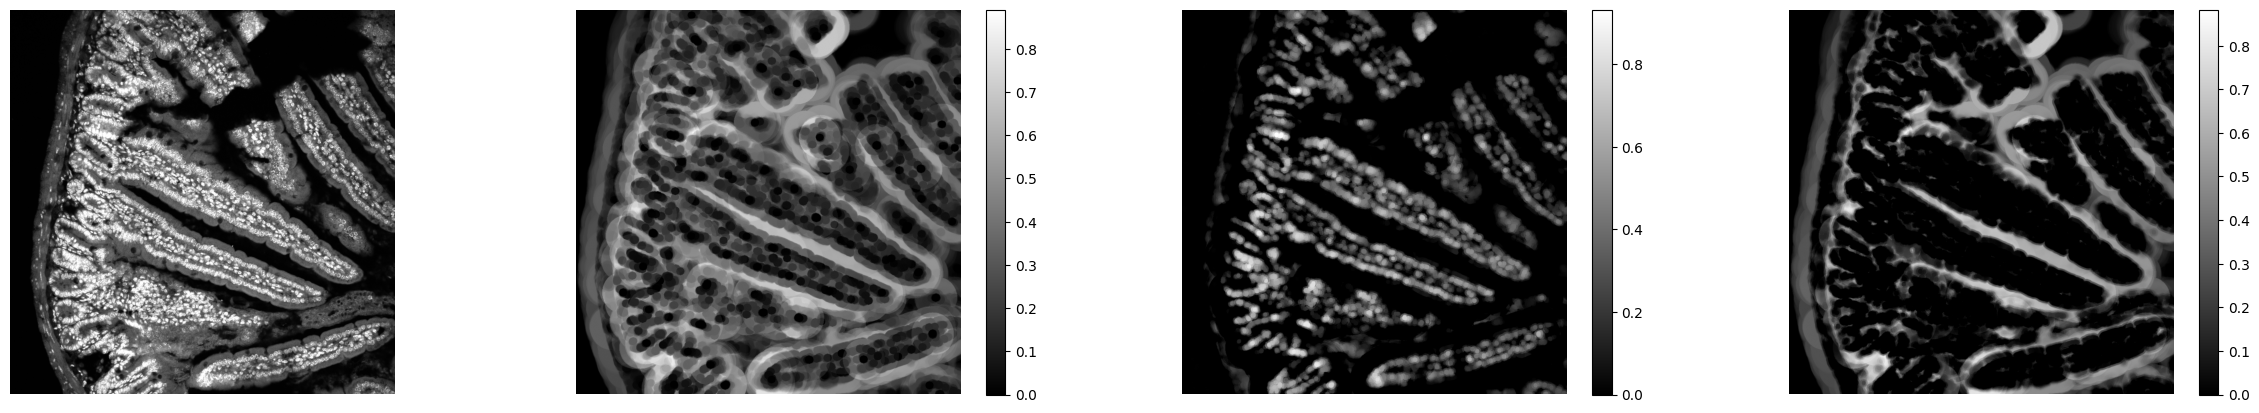

In [72]:
hats,clean,outer_trophs =show_caps( minmax(tissue_image), 5, 50)
outer_trophs = minmax(outer_trophs)
print(hats.shape, clean.shape, outer_trophs.shape)

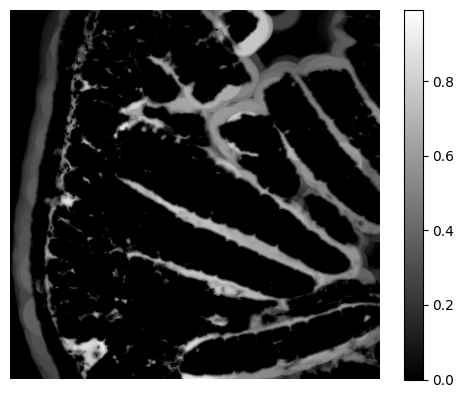

In [73]:
plt.imshow(np.maximum(outer_trophs-minmax(tissue_image),0), cmap='gray'); plt.axis('off'); plt.colorbar(); plt.show()

(1024, 1024) (1024, 1024) (1024, 1024)


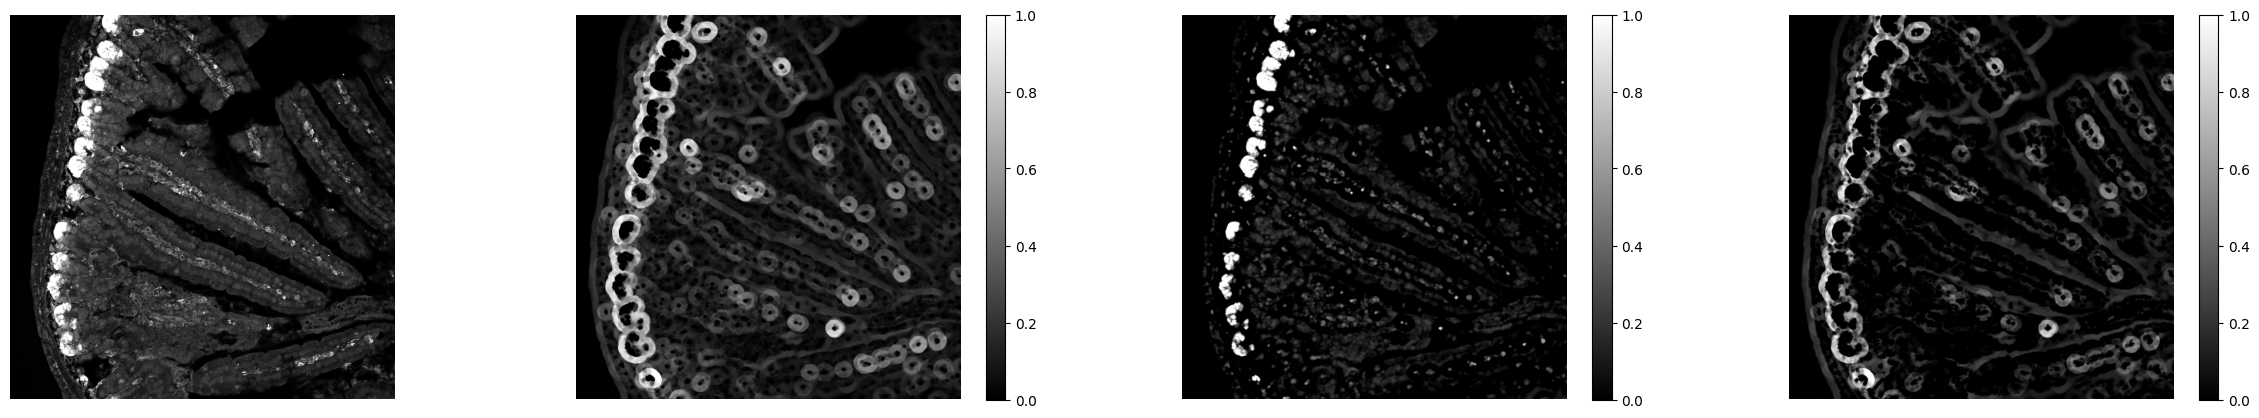

In [37]:
crypt_hats, crypt_clean, crypt_troughs = show_caps(minmax(crypt_img), 2, 20)
print(crypt_hats.shape, crypt_clean.shape, crypt_troughs.shape)

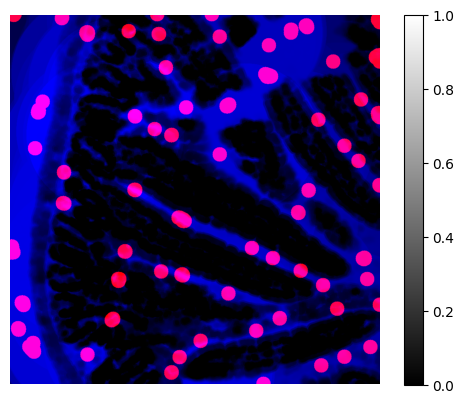

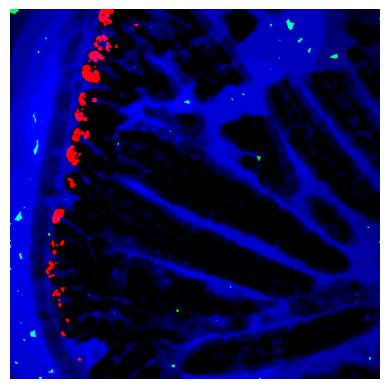

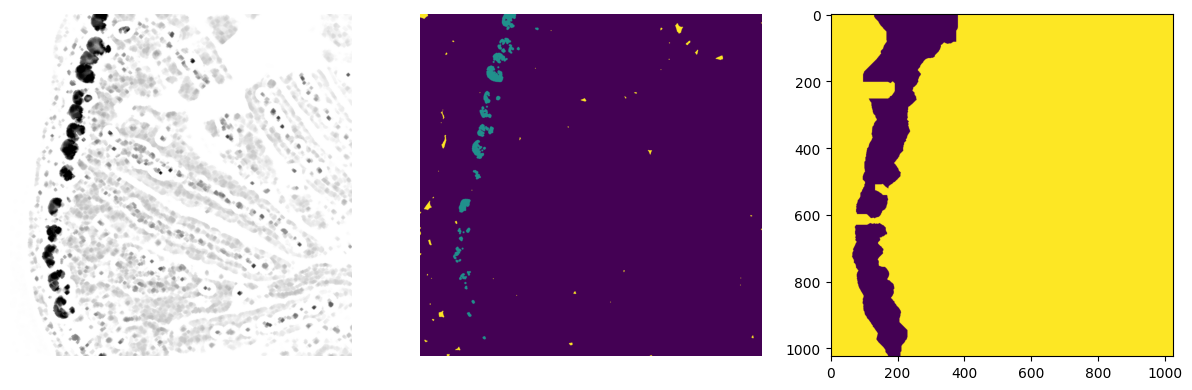

In [71]:
from skimage.morphology import footprint_rectangle, ball, binary_opening, binary_closing, star
from skimage.morphology import white_tophat, black_tophat
from skimage.util import invert
from scipy.ndimage import distance_transform_edt  as dst
outer_trophs_internal = outer_trophs.copy()
#outer_trophs_internal = outer_trophs_internal-white_tophat(outer_trophs_internal, footprint=footprint_rectangle((1,1)))

 
a_bin = binary_opening(local_maxima(
        crypt_clean,
        ),
        footprint=disk(3)
   )


plt.imshow(np.stack([
    local_maxima(opening(outer_trophs_internal, footprint=disk(20))), 
    np.zeros_like(outer_trophs_internal), 
    outer_trophs_internal,
    ], axis=-1), cmap='gray'); plt.axis('off');plt.colorbar(); plt.show()



b = binary_opening( local_maxima(erosion(outer_trophs_internal, footprint=disk(10)), connectivity=1), disk(1))


plt.imshow(np.stack([a_bin, b, outer_trophs], axis=-1), ); plt.axis('off'); plt.show()

#wack = - minmax(distance_transform_edt(outer_trophs==0)) + minmax(distance_transform_edt(outer_trophs>0))
alt = (np.maximum(invert(dilation(minmax(crypt_clean), footprint=disk(2))), (minmax(outer_trophs))))

# wack = dst(input = ~a_bin)

# plt.imshow(wack); plt.axis('off'); plt.show()

spread = watershed(
    image = alt,
    markers = np.maximum((a_bin*1),(b*2))
)



fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(alt, cmap='gray'); ax[0].axis('off');
ax[1].imshow(np.maximum((a_bin*1),(b*2)), ); ax[1].axis('off');
ax[2].imshow(spread)

In [26]:
from numpy.typing import NDArray
from typing import Tuple, Optional
crypt_img = list_of_images_to_try[0][1]
tissue_image = list_of_images_to_try[0][2]
blob_size_px = 1
def identify_crypt_seeds(crypt_img: NDArray, tissue_image: NDArray, blob_size_px: Optional[int] = None):
    

    tissue_hats, tissue_clean, tissue_troughs = caps(
        equalize_adapthist(tissue_image), 
        1, 
        20)
    crypt_hats, crypt_clean, crypt_troughs = caps(crypt_img, 2, 20)

    thinned_crypts = np.maximum( crypt_clean - tissue_clean, 0)#crypt_clean - np.minimum(crypt_clean, tissue_clean)
    split_crypts = np.maximum(crypt_clean - tissue_troughs, 0)

    good_crypts = minmax(
        opening(
            split_crypts * thinned_crypts,
            footprint = disk(radius=5)
            )**(1/2)
        )
    distance = tissue_troughs - good_crypts
    maxi = local_maxima(good_crypts)
    crypt_seeds = label(
        watershed(
            distance,
            markers = maxi,
            mask = tissue_troughs<good_crypts
        )
    )
    return crypt_seeds



def limited_expansion( # this is where use tissyue to limit the vertical expansion of the crypts
        crypt_img: NDArray, tissue_image: NDArray, blob_size_px: Optional[int] = None
        ) :
    
    hats,clean,outer_trophs =caps( minmax(tissue_image), 10, 50)
    #crypt_hats, crypt_clean, crypt_troughs = show_caps(minmax(crypt_img), 2, 20)

    outer_trophs = minmax(outer_trophs)
    a_int = np.maximum(
                crypt_img-outer_trophs,0
                )        
    a_bin = (binary_opening(
        local_maxima(
            a_int,
            indices=False
            ),
            footprint=disk(1)
            )).astype(bool)


    b = binary_opening( local_maxima(outer_trophs), disk(2))

    alt = invert(dilation(minmax(a_int), footprint=disk(2)) + minmax(outer_trophs))



    spread = watershed(
        image = alt,
        markers = np.maximum((a_bin*1),(b*2))
    )
    
    return spread



In [27]:

def identify_tissue_seeds() -> NDArray[np.int_]:
    


def clean_up_tissue_to_more_complete_boundries(limited_expanded_crypts: NDArray[np.bool], blob_size_px: int) -> NDArray[np.bool_]: #should return a binary mask of tissue
    erosion_kernel_size = max(3, int(round(effective_blob * 0.15)))
    if erosion_kernel_size % 2 == 1:
        erosion_kernel_size += 1
    cv_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (erosion_kernel_size, erosion_kernel_size))
    mask_u8 = mask_gt_red.astype(np.uint8) * 255
    erosion_iterations = max(1, int(round(effective_blob / 20.0)))
    mask_eroded_u8 = cv2.erode(mask_u8, cv_kernel, iterations=erosion_iterations)
    
    
    
    cleaned_tissue  = over_expanded_tissue and (limited_expanded_crypts is 0)
    return cleaned_tissue





def watershed_for_full_crypts(
        crypt_seeds: NDArray[np.int_],
        cleaned_tissue: NDArray[np.bool_],
        ) -> NDArray[np.int_]:
    
    altitude_map =
    seeds = 

    return full_crypts

labeled_lysozyme_to_crypt_map = watershed_for_full_crypts()

IndentationError: expected an indented block after function definition on line 1 (2463440952.py, line 5)

In [ ]:
scale = 5
width = 4
fig, ax = plt.subplots(len(list_of_images_to_try),width, figsize=(scale*width, len(list_of_images_to_try)*scale))
for i, image_set in enumerate(list_of_images_to_try):

    subject, crypt_img, tissue_img = image_set
    crypt_img, tissue_img = minmax(crypt_img), minmax(tissue_img)
    ax[i,0].imshow(
        np.stack(
            [crypt_img, np.zeros_like(crypt_img), tissue_img], 
            axis=-1)
            ); ax[i,0].axis('off'); ax[i,0].set_title(f"{subject} - Crypt")
    ax[i,1].imshow(label2rgb(identify_crypt_seeds(crypt_img, tissue_img))); ax[i,1].axis('off'); ax[i,1].set_title(f"{subject} - crypt seeds")
    ax[i,2].imshow(limited_expansion(crypt_img, tissue_img), cmap='nipy_spectral'); ax[i,2].axis('off'); ax[i,2].set_title(f"{subject} - Limited Expansion")
    #ax[i,2].imshow(identify_potential_crypts(crypt_img, tissue_img, debug=False), cmap='nipy_spectral'); ax[i,2].axis('off'); ax[i,2].set_title(f"{subject} - Segmented Crypts")
    #ax[i,3].imshow(new_identify_potential_crypts(crypt_img, tissue_img, debug=False), cmap='nipy_spectral'); ax[i,3].axis('off'); ax[i,3].set_title(f"{subject} - New Segmented Crypts")
fig.show()

In [ ]:
import cv2
from scipy.ndimage import label as ndi_label
from skimage.segmentation import expand_labels
from scipy.ndimage import distance_transform_edt

def new_identify_potential_crypts(crypt_img, tissue_image, blob_size_px=30, debug=False):
    """Identify potential crypt regions using the original watershed pipeline."""

    if crypt_img.shape != tissue_image.shape:
        raise ValueError(f"Image shape mismatch: red {crypt_img.shape} vs blue {tissue_image.shape}")


    




    effective_blob = float(blob_size_px) if blob_size_px else 1.0
    erosion_dim = max(3, int(round(effective_blob / 10.0)))
    if erosion_dim % 2 == 0:
        erosion_dim += 1
    erosion_footprint = np.ones((erosion_dim, erosion_dim), dtype=bool)

    # first get tight crypt seeds

    crypt_seeds = crypt_img > np.minimum(tissue_image, crypt_img)

 

    min_region_area = max(20, int(round((effective_blob ** 2) / 16.0)))
    crypt_seeds = morphology.binary_erosion(crypt_seeds, footprint=erosion_footprint)
    crypt_seeds = morphology.remove_small_objects(crypt_seeds, min_size=min_region_area)


    abs_diff = np.maximum(tissue_image - crypt_img, 0)
    mask_gt_red = abs_diff > crypt_img



    erosion_kernel_size = max(3, int(round(effective_blob * 0.15)))
    if erosion_kernel_size % 2 == 1:
        erosion_kernel_size += 1
    cv_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (erosion_kernel_size, erosion_kernel_size))
    mask_u8 = mask_gt_red.astype(np.uint8) * 255
    erosion_iterations = max(1, int(round(effective_blob / 20.0)))
    mask_eroded_u8 = cv2.erode(mask_u8, cv_kernel, iterations=erosion_iterations)
    tissue_eroded = mask_eroded_u8.astype(bool)



    combined_labels = np.zeros_like(crypt_seeds, dtype=int)
    combined_labels[tissue_eroded] = 2 # tissue
    combined_labels[crypt_seeds] = 1



    expand_distance = max(1, int(round(effective_blob * 2.5)))
    expanded_labels = expand_labels(combined_labels, distance=expand_distance)



    labeled_diff_r, _ = ndi_label(input = (crypt_seeds > 0))



    reworked = np.zeros_like(expanded_labels, dtype=np.int32)
    reworked[expanded_labels == 2] = 1
    mask_copy = (expanded_labels != 2) & (labeled_diff_r != 0)
    reworked[mask_copy] = labeled_diff_r[mask_copy] + 1



    mask_ws = expanded_labels > 0


    elevation = (
        minmax(distance_transform_edt(combined_labels == 2))
        - minmax(distance_transform_edt(combined_labels == 1))
    )



    ws_labels = watershed(elevation, markers=reworked, mask=mask_ws)




    ws_labels = ws_labels.copy()
    ws_labels[ws_labels == 1] = 0 # set tissue to background
    ws_labels[ws_labels > 1] = ws_labels[ws_labels > 1] - 1 # flip down



    return ws_labels

In [ ]:
scale = 5
width = 4
fig, ax = plt.subplots(len(list_of_images_to_try),width, figsize=(scale*width, len(list_of_images_to_try)*scale))

for i, image_set in enumerate(list_of_images_to_try):

    subject, crypt_img, tissue_img = image_set
    crypt_img, tissue_img = minmax(crypt_img), minmax(tissue_img)
    ax[i,0].imshow(crypt_img, cmap='Reds'); ax[i,0].axis('off'); ax[i,0].set_title(f"{subject} - Crypt")
    ax[i,1].imshow(tissue_img, cmap='Blues'); ax[i,1].axis('off'); ax[i,1].set_title(f"{subject} - Tissue")
    ax[i,2].imshow(identify_potential_crypts(crypt_img, tissue_img, debug=False), cmap='nipy_spectral'); ax[i,2].axis('off'); ax[i,2].set_title(f"{subject} - Segmented Crypts")
    ax[i,3].imshow(new_identify_potential_crypts(crypt_img, tissue_img, debug=False), cmap='nipy_spectral'); ax[i,3].axis('off'); ax[i,3].set_title(f"{subject} - New Segmented Crypts")
fig.show()


